In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import time
import seaborn as sns
from IPython.display import clear_output


import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
 
import seedlingTools as st

In [2]:
def plot_gray_histogram(img):
    plt.figure(figsize=(15,5))
    plt.hist(img.ravel(),256,[0,256])
    plt.grid()
    plt.show()

In [3]:
imageDirectory = "/media/jee/Shared Partition/camera/pre-move/day"
imageList = st.get_image_list(imageDirectory)

Searching in : /media/jee/Shared Partition/camera/pre-move/day
Found 160 .jpg images.


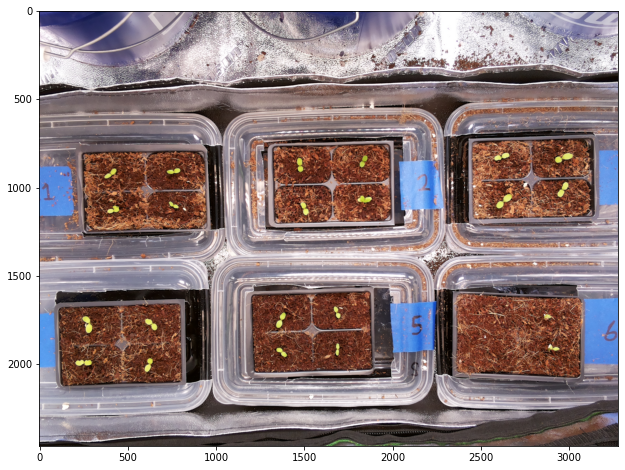

In [4]:
# Show an image form imageList
st.show_image_file(imageList[100])

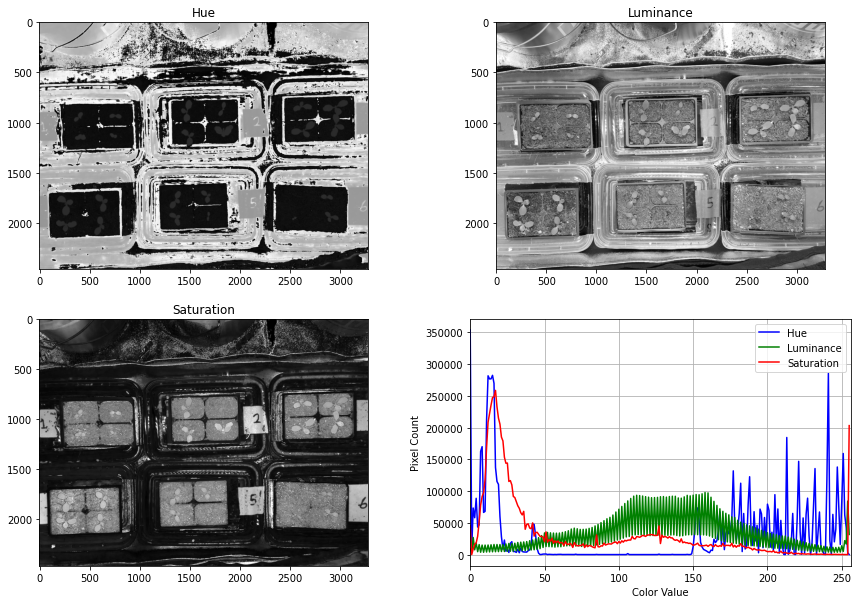

In [5]:
st.plot_image_file_histogram_hls(imageList[159])

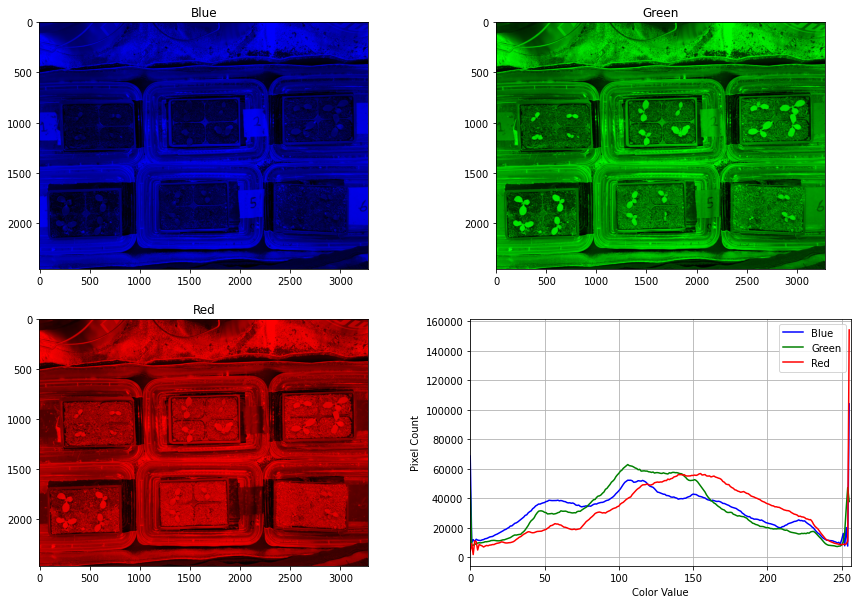

In [6]:
st.plot_image_file_histogram_bgr(imageList[159])

In [7]:
df = st.get_color_averages(imageList)

In [8]:
df.head()

file  saturationMean  \
0  /media/jee/Shared Partition/camera/pre-move/da...       68.579660   
1  /media/jee/Shared Partition/camera/pre-move/da...       64.539807   
2  /media/jee/Shared Partition/camera/pre-move/da...       66.225576   
3  /media/jee/Shared Partition/camera/pre-move/da...       66.987249   
4  /media/jee/Shared Partition/camera/pre-move/da...       66.273441   

   luminanceMean     hueMean    blueMean   greenMean     redMean  
0     117.275029  118.094622  110.794862  108.386709  125.852382  
1     118.036268  130.116226  114.161195  109.156956  124.487011  
2     116.974241  131.260391  111.837732  107.286122  125.148766  
3     115.656008  132.174986  111.624772  106.098959  122.907406  
4     115.296053  130.911190  111.602331  105.846755  121.833971

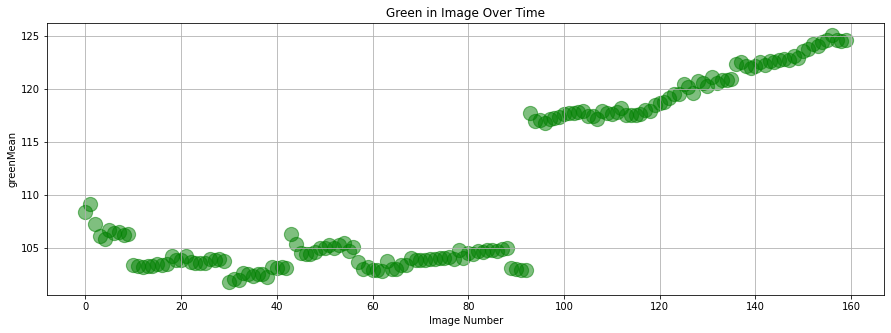

In [9]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=df.index, y='greenMean', data=df, s=200, edgecolor=None,
                alpha=0.5, color='green')
plt.xlabel('Image Number')
plt.title("Green in Image Over Time")
plt.grid()

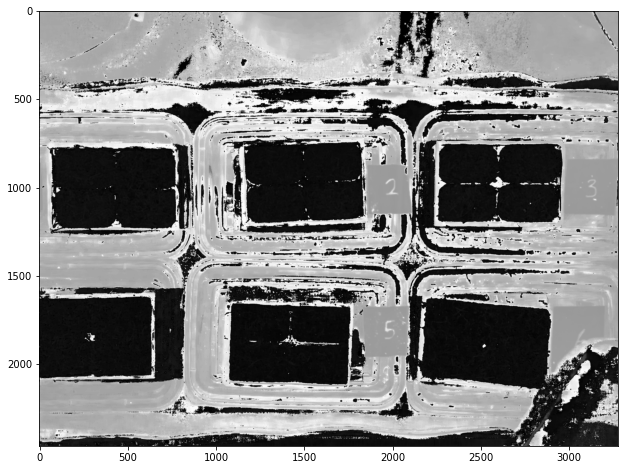

In [16]:
img = cv2.imread(imageList[10])
imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)
imgHue = imgHLS[:,:,0]
# imgHueBlurred = cv2.blur(imgHue, (300,200))
imgHueBlurred = cv2.blur(imgHue, (3,3))
st.show_image(imgHueBlurred, cmap='gray')

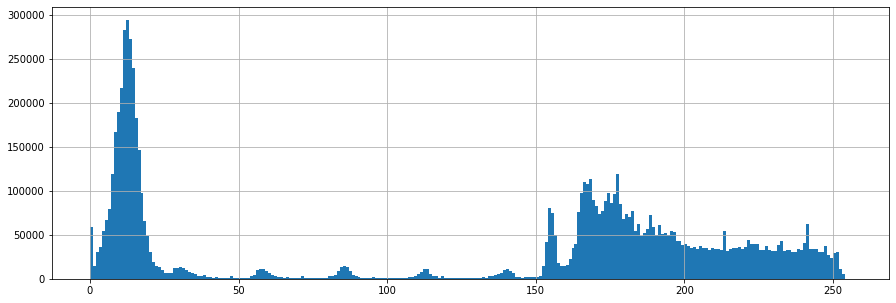

In [17]:
plot_gray_histogram(imgHueBlurred)

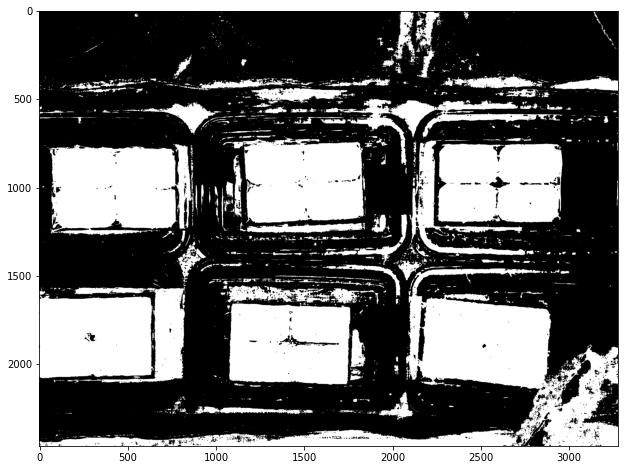

In [18]:
ret, thresh = cv2.threshold(imgHueBlurred, 50, 255, cv2.THRESH_BINARY_INV)
st.show_image(thresh, cmap='gray')

In [19]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [20]:
externalContours = np.zeros(thresh.shape)
internalContours = np.zeros(thresh.shape)

In [22]:
for i in range(len(contours)):
    # external contours
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(externalContours, contours, i, 255, -1)

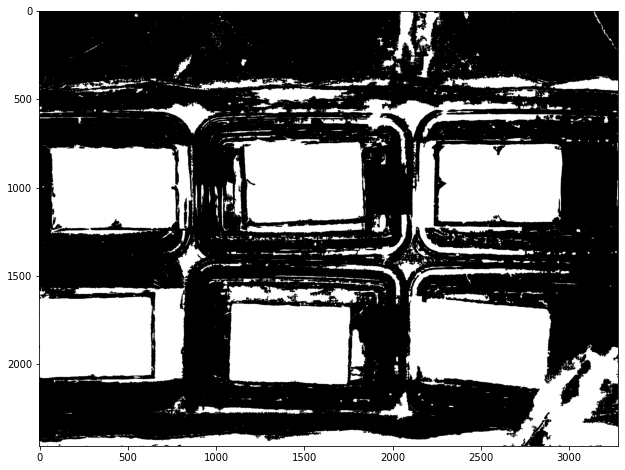

In [23]:
st.show_image(externalContours, cmap='gray')

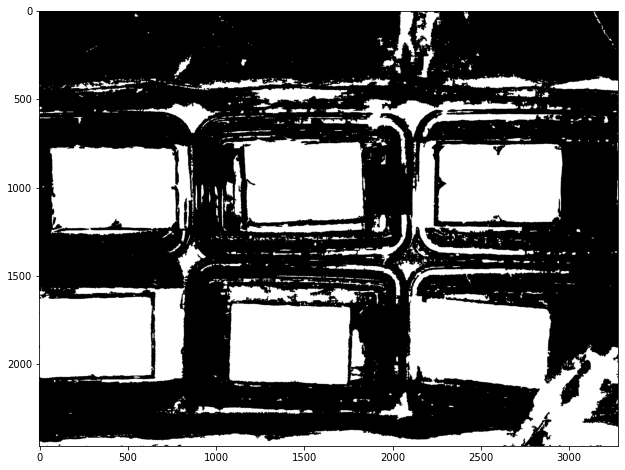

In [24]:
kernel = np.ones((3,3), dtype=np.uint8)
opening = cv2.morphologyEx(externalContours, cv2.MORPH_OPEN, kernel, iterations=1)
st.show_image(opening, cmap='gray')

In [25]:
hueDistanceTransform = cv2.distanceTransform(opening.astype(np.uint8), cv2.DIST_L2, 5).astype(np.uint8)

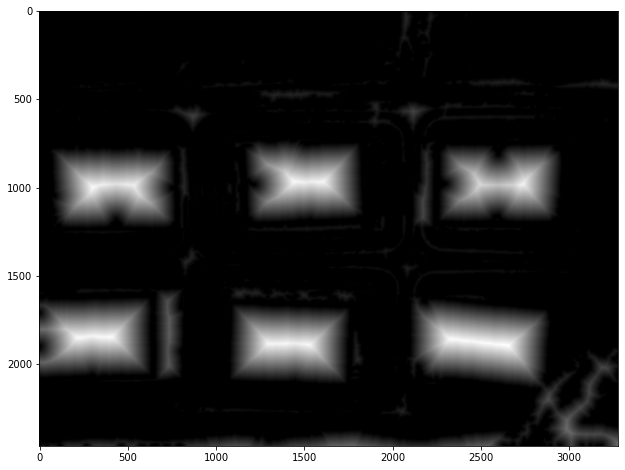

In [26]:
st.show_image(hueDistanceTransform, cmap='gray')

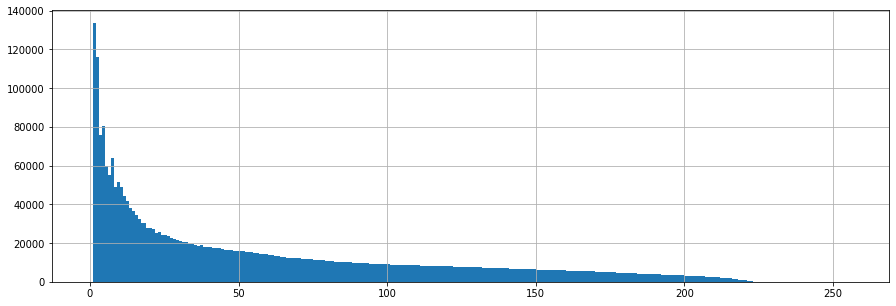

In [27]:
plot_gray_histogram(hueDistanceTransform[hueDistanceTransform!=0])

In [28]:
0.75*np.max(hueDistanceTransform)

168.75

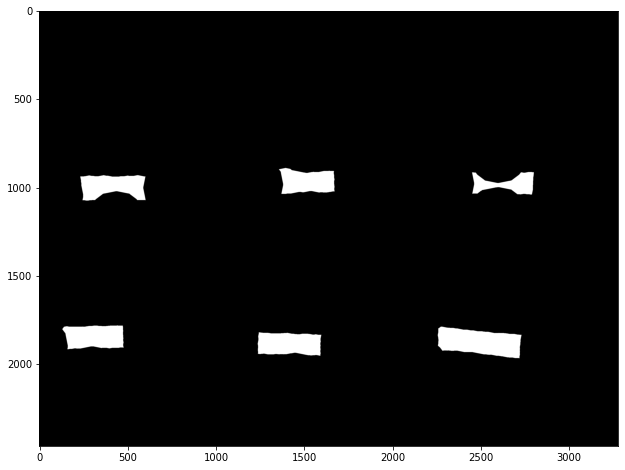

In [29]:
ret, distanceThresh = cv2.threshold(hueDistanceTransform, 0.7*np.max(hueDistanceTransform), 255, cv2.THRESH_BINARY)
st.show_image(distanceThresh, cmap='gray')

In [30]:
def generate_seeds(file):
    img = cv2.imread(file)
    imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)
    imgHue = imgHLS[:,:,0]
    imgHueBlurred = cv2.blur(imgHue, (300,300))
    ret, thresh = cv2.threshold(imgHueBlurred, 30, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    externalContours = np.zeros(thresh.shape)
    internalContours = np.zeros(thresh.shape)
    for i in range(len(contours)):
        # external contours
        if hierarchy[0][i][3] == -1:
            cv2.drawContours(externalContours, contours, i, 255, -1)
    kernel = np.ones((3,3), dtype=np.uint8)
    opening = cv2.morphologyEx(externalContours, cv2.MORPH_OPEN, kernel, iterations=1)
    hueDistanceTransform = cv2.distanceTransform(opening.astype(np.uint8), cv2.DIST_L2, 5).astype(np.uint8)
    ret, distanceThresh = cv2.threshold(hueDistanceTransform, 0.5*np.max(hueDistanceTransform), 255, cv2.THRESH_BINARY)
    return distanceThresh

def generate_thresh_contours(file):
    img = cv2.imread(file)
    imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)
    imgHue = imgHLS[:,:,0]
    imgHueBlurred = cv2.blur(imgHue, (300,300))
    ret, thresh = cv2.threshold(imgHueBlurred, 30, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    externalContours = np.zeros(thresh.shape)
    internalContours = np.zeros(thresh.shape)
    for i in range(len(contours)):
        # external contours
        if hierarchy[0][i][3] == -1:
            cv2.drawContours(externalContours, contours, i, 255, -1)
    return externalContours

def generate_saturation_thresh_contours(file):
    img = cv2.imread(file)
    imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)
    imgSaturation = imgHLS[:,:,2]
    imgSaturationBlurred = cv2.blur(imgSaturation, (300,300))
    ret, thresh = cv2.threshold(imgSaturationBlurred, 110, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    externalContours = np.zeros(thresh.shape)
    internalContours = np.zeros(thresh.shape)
    for i in range(len(contours)):
        # external contours
        if hierarchy[0][i][3] == -1:
            cv2.drawContours(externalContours, contours, i, 255, -1)
    return externalContours

In [31]:
for i, file in enumerate(imageList):
    print("Processed Image: {}/{}".format(i+1, len(imageList)), end='\r')
    threshImage = generate_thresh_contours(file)
    threshFile = "contours-thresh".join(file.split('day'))
    cv2.imwrite(threshFile, threshImage)

In [32]:
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/contours-thresh/")

FileNotFoundError: [Errno 2] No such file or directory: '/media/jee/Shared Partition/camera/pre-move/contours-thresh/'

In [ ]:
for i, file in enumerate(imageList):
    print("Processed Image: {}/{}".format(i+1, len(imageList)), end='\r')
    threshImage = generate_seeds(file)
    threshFile = "distance-thresh".join(file.split('day'))
    cv2.imwrite(threshFile, threshImage)

In [ ]:
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/distance-thresh/")

In [ ]:
for i, file in enumerate(imageList):
    print("Processed Image: {}/{}".format(i+1, len(imageList)), end='\r')
    threshImage = generate_saturation_thresh_contours(file)
    threshFile = "saturation-contours-thresh".join(file.split('day'))
    cv2.imwrite(threshFile, threshImage)

# Feature Matching

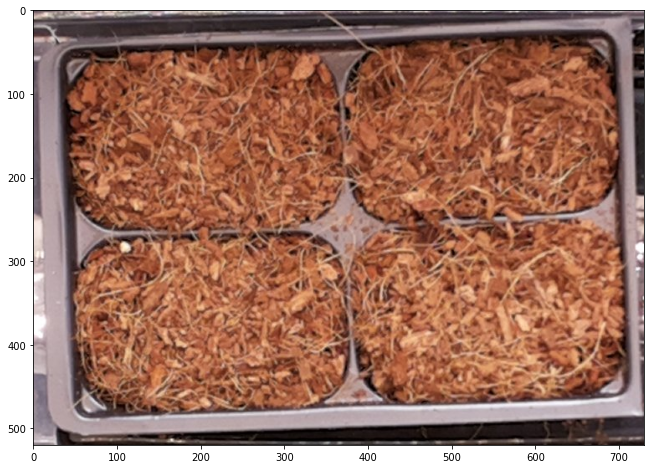

In [29]:
template = cv2.imread("/media/jee/Shared Partition/camera/pre-move/template.jpg")
templateRGB = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
st.show_image(templateRGB)

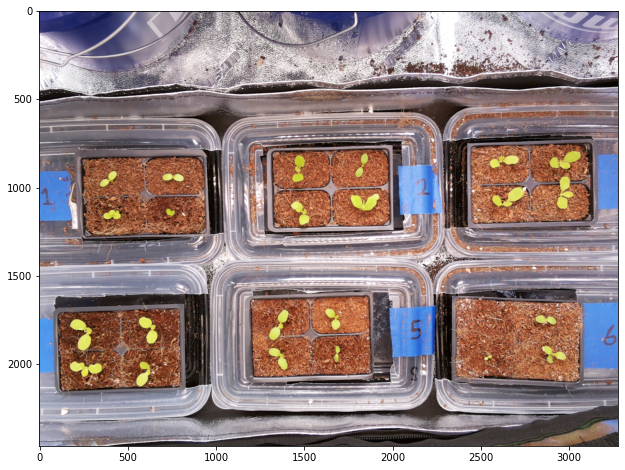

In [30]:
target = cv2.imread(imageList[150])
targetRGB = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
st.show_image(targetRGB)

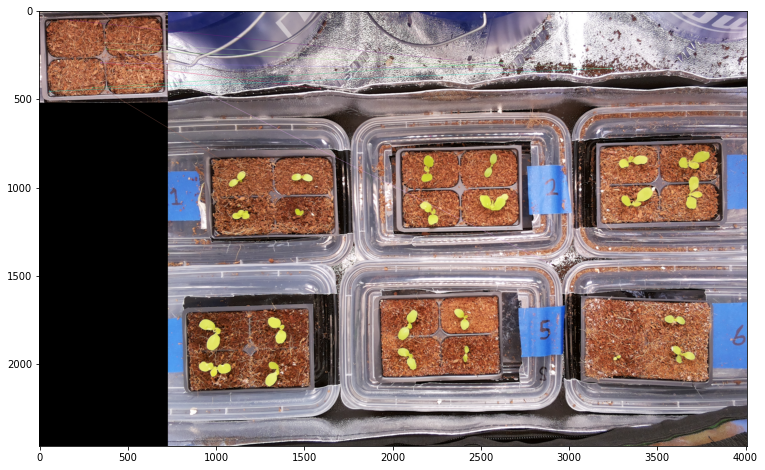

In [31]:
orb = cv2.ORB_create()
keyPoints1, descriptor1 = orb.detectAndCompute(templateRGB, None)
keyPoints2, descriptor2 = orb.detectAndCompute(targetRGB, None)

# brute force matching
bruteForce = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bruteForce.match(descriptor1, descriptor2)
matches = sorted(matches, key=lambda x : x.distance)
templateMatches = cv2.drawMatches(templateRGB, keyPoints1, targetRGB,
                                  keyPoints2, matches[:10], None, flags=2)
st.show_image(templateMatches)

In [32]:
# SIFT
sift = cv2.SIFT_create()
keyPoints1, descriptor1 = sift.detectAndCompute(template, None)
keyPoints2, descriptor2 = sift.detectAndCompute(target, None)

# brute force matching
bruteForce = cv2.BFMatcher()
matches = bruteForce.knnMatch(descriptor1, descriptor2, k=2)

good = []
for match1, match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])
        
print(len(good), len(matches))

15 7439


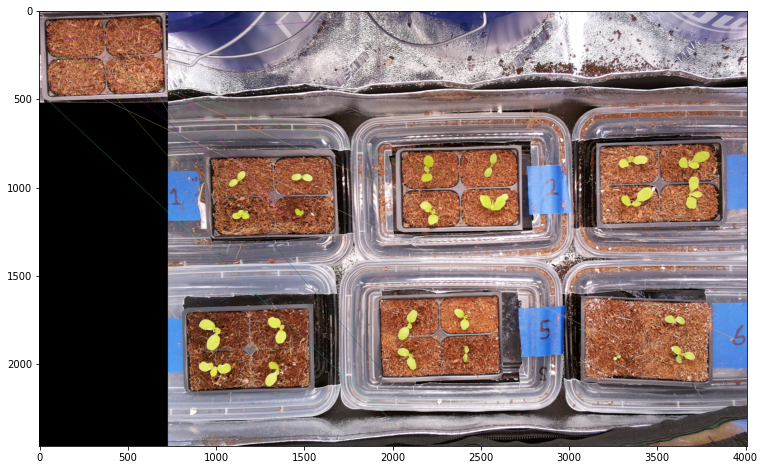

In [33]:
sift_matches = cv2.drawMatchesKnn(templateRGB, keyPoints1, targetRGB,
                                  keyPoints2, good[:10], None, flags=2)
st.show_image(sift_matches)

(2464, 3280, 3)


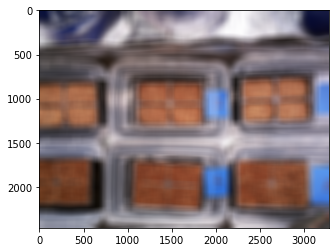

In [34]:
pic = plt.imread(imageList[0])/255  # dividing by 255 to bring the pixel values between 0 and 1
pic = cv2.blur(pic, (100,100))
print(pic.shape)
plt.imshow(pic)

In [35]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(8081920, 3)

In [36]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

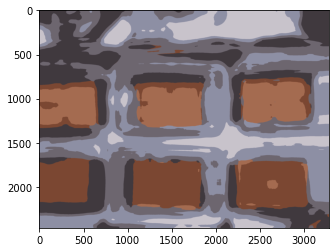

In [37]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

# Just Draw some lines...

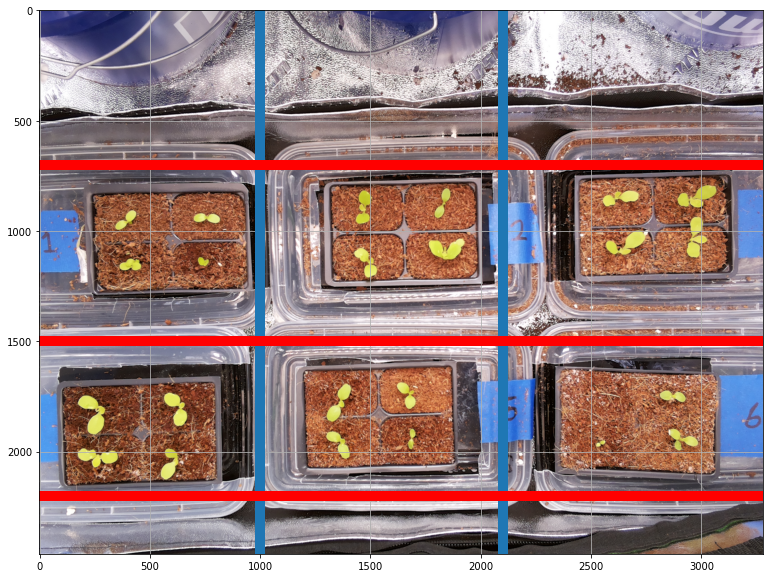

In [74]:
plt.figure(figsize=(15,10))
plt.imshow(targetRGB)
plt.axvline(1000, linewidth=10)
plt.axvline(2100, linewidth=10)
plt.axhline(700, linewidth=10, color = 'r')
plt.axhline(1500, linewidth=10, color = 'r')
plt.axhline(2200, linewidth=10, color = 'r')
plt.grid()

In [75]:
def generate_simple_line_plot(file):
    image = cv2.imread(file)
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15,10))
    plt.imshow(imageRGB)
    plt.axvline(1000, linewidth=10)
    plt.axvline(2100, linewidth=10)
    plt.axhline(700, linewidth=10, color = 'r')
    plt.axhline(1500, linewidth=10, color = 'r')
    plt.axhline(2200, linewidth=10, color = 'r')
    plt.savefig(file.replace('day', 'simple-lines'))
    plt.close()

In [76]:
for i, file in enumerate(imageList):
    print("Processed Image: {}/{}".format(i+1, len(imageList)), end='\r')
    generate_simple_line_plot(file)

In [77]:
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/simple-lines/", 10)

In [80]:
for i, file in enumerate(imageList):
    print("Processed Image: {}/{}".format(i+1, len(imageList)), end='\r')
    image = cv2.imread(file)
    y1 = 700
    y2 = 1500
    y3 = 2200
    x1 = 0
    x2 = 1000
    x3 = 2100
    x4 = image.shape[1]
    cv2.imwrite(file.replace('day','1'), image[y1:y2,x1:x2])
    cv2.imwrite(file.replace('day','2'), image[y1:y2,x2:x3])
    cv2.imwrite(file.replace('day','3'), image[y1:y2,x3:x4])
    cv2.imwrite(file.replace('day','4'), image[y2:y3,x1:x2])
    cv2.imwrite(file.replace('day','5'), image[y2:y3,x2:x3])
    cv2.imwrite(file.replace('day','6'), image[y2:y3,x3:x4])

In [81]:
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/1/")
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/2/")
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/3/")
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/4/")
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/5/")
st.create_timelapse("/media/jee/Shared Partition/camera/pre-move/6/")

In [ ]:
for i, file in enumerate(imageList):
    print("Processed Image: {}/{}".format(i+1, len(imageList)), end='\r')
    image = cv2.imread(file)
    
    y1 = 700
    y2 = 1500
    y3 = 2200
    x1 = 0
    x2 = 1000
    x3 = 2100
    x4 = image.shape[1]
    cv2.imwrite(file.replace('day','1'), image[y1:y2,x1:x2])
    cv2.imwrite(file.replace('day','2'), image[y1:y2,x2:x3])
    cv2.imwrite(file.replace('day','3'), image[y1:y2,x3:x4])
    cv2.imwrite(file.replace('day','4'), image[y2:y3,x1:x2])
    cv2.imwrite(file.replace('day','5'), image[y2:y3,x2:x3])
    cv2.imwrite(file.replace('day','6'), image[y2:y3,x3:x4])